"¿Cómo influyen los indicadores económicos y demográficos en la tasa de crecimiento de la población en España?"

In [372]:
# Importación de librerías necesarias
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination, ApproxInference, BeliefPropagation
from pgmpy.estimators import BayesianEstimator
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

from pandas import read_csv, DataFrame
import numpy as np

In [373]:


# Definir constantes para los nodos de la red bayesiana
LV_EDU = "% de personas mayores de 25 años con al menos la ESO"  # SE.SEC.CUAT.UP.ZS
LV_URB = "Porcentaje de población urbana"                        # SP.URB.TOTL.IN.ZS
RT_PARO = "Tasa de paro"                                         # SL.UEM.TOTL.ZS
PNB = "Ingreso nacional bruto"                                   # NY.GNP.PCAP.CD
PIB = "Producto Interior Bruto"            #GDP                  # NY.GDP.PCAP.KD.ZG
GASTO_EDUCATIVO = "Gasto educativo"                              # SE.XPD.TOTL.GD.ZS
GASTO_SALUD = "Gastos en salud"                                  # SH.XPD.CHEX.PC.CD
RT_FERTILIDAD = "Tasa de fertilidad"                             # SP.DYN.TFRT.IN
RT_MORTALIDAD = "Tasa de mortalidad"                         
MIGRACION_NETA = "Migracion neta"                                # SM.POP.NETM
RT_CRECIMIENTO = "Tasa de crecimiento de la población"           # SP.POP.GROW

# Se crea el objeto para el model 
model = BayesianNetwork()

# Añadimos todos los nodos
nodes = [
    RT_CRECIMIENTO, PIB, RT_PARO, GASTO_EDUCATIVO, GASTO_SALUD, PNB, LV_URB, RT_FERTILIDAD, RT_MORTALIDAD,
    MIGRACION_NETA, LV_EDU]

model.add_nodes_from(nodes)

#Creamos y añadimos los caminos (origen, destino) del grafo dirigido
edges_RT_PARO = [
    (LV_EDU, RT_PARO), 
    (LV_URB, RT_PARO)
    ]
edges_PIB = [
    (RT_PARO, PIB), 
    (PNB, PIB)
    ]
edges_RT_FERTILIDAD = [
    (GASTO_EDUCATIVO, RT_FERTILIDAD), 
    (GASTO_SALUD, RT_FERTILIDAD)
    ]
edges_RT_CRECIMIENTO = [
    (MIGRACION_NETA, RT_CRECIMIENTO),
    (RT_FERTILIDAD, RT_CRECIMIENTO), 
    (RT_MORTALIDAD, RT_CRECIMIENTO)
    ]

model.add_edges_from(edges_RT_PARO)
model.add_edges_from(edges_PIB)
model.add_edge(PIB, GASTO_EDUCATIVO)
model.add_edge(PIB, GASTO_SALUD)
model.add_edges_from(edges_RT_FERTILIDAD)
model.add_edge(GASTO_SALUD, RT_MORTALIDAD)
model.add_edges_from(edges_RT_CRECIMIENTO)


In [374]:
years = {"min" : 1975, "max" : 2022}
df_raw = read_csv("./csv/data.csv", delimiter=';')
        
df_raw_growth = DataFrame(df_raw[:])
print("There are " + str(df_raw_growth.shape[0]) + " indicators in the dataframe.")
df_raw_growth.head()

There are 11 indicators in the dataframe.


,Year,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Population growth (annual %),1.081294,1.056852,1.029132,0.962877,0.881585,0.802964,0.710878,0.600390,0.487183,...,-0.327669,-0.298951,-0.077589,0.084430,0.234588,0.437983,0.717716,0.488502,0.105799,0.761702
1,GDP per capita growth (annual %),-0.539097,2.217773,1.785657,0.490728,-0.836528,1.391315,-0.839887,0.640409,1.275515,...,-1.079741,1.699353,3.919117,2.950816,2.734475,1.837460,1.254632,-11.600189,6.290659,4.968051
2,"Unemployment, total (% of total labor force) (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.090000,24.440000,22.060000,19.640000,17.220000,15.250000,14.100000,15.530000,14.780000,12.920000
3,"Educational attainment, at least completed upp...",NaN,NaN,NaN,NaN,NaN,NaN,12.833750,NaN,NaN,...,47.237251,47.863049,48.649059,49.865326,50.416988,52.195572,53.256748,54.987942,55.349281,NaN
4,Current health expenditure per capita (current...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2629.466797,2679.476563,2349.093750,2376.601074,2524.684814,2741.382568,2716.833496,2899.018799,3234.292969,NaN


In [375]:
df_growth = df_raw_growth.transpose().iloc[1:]
df_growth.columns = nodes
df_growth

,Tasa de crecimiento de la población,Producto Interior Bruto,Tasa de paro,Gasto educativo,Gastos en salud,Ingreso nacional bruto,Porcentaje de población urbana,Tasa de fertilidad,Tasa de mortalidad,Migracion neta,% de personas mayores de 25 años con al menos la ESO
1975,1.081294,-0.539097,NaN,NaN,NaN,3240.0,69.57,2.77,298192.0,1177.0,NaN
1976,1.056852,2.217773,NaN,NaN,NaN,3430.0,70.231,2.77,299007.0,4854.0,1.89939
1977,1.029132,1.785657,NaN,NaN,NaN,3640.0,70.883,2.65,294324.0,195.0,2.07717
1978,0.962877,0.490728,NaN,NaN,NaN,4040.0,71.527,2.54,296781.0,-1893.0,2.23073
1979,0.881585,-0.836528,NaN,NaN,NaN,5010.0,72.162,2.37,291213.0,-6124.0,2.33805
1980,0.802964,1.391315,NaN,NaN,NaN,6210.0,72.789,2.22,289344.0,15108.0,NaN
1981,0.710878,-0.839887,NaN,12.83375,NaN,6310.0,73.279,2.04,293386.0,-6044.0,NaN
1982,0.60039,0.640409,NaN,NaN,NaN,5680.0,73.515,1.94,286655.0,-16439.0,NaN
1983,0.487183,1.275515,NaN,NaN,NaN,4860.0,73.749,1.8,302569.0,-21369.0,NaN
1984,0.415256,1.362897,NaN,NaN,NaN,4580.0,73.982,1.73,299409.0,-18090.0,NaN


In [376]:
TIERS_NUM = 3

def boundary_str(start, end, tier):
    return f'{tier}: {start:+0,.2f} to {end:+0,.2f}'

def relabel(v, boundaries):
    if v >= boundaries[0][0] and v <= boundaries[0][1]:
        return "3_BAJO" # boundary_str(boundaries[0][0], boundaries[0][1], tier="3_BAJO")
    elif v >= boundaries[1][0] and v <= boundaries[1][1]:
        return "2_MEDIO" # boundary_str(boundaries[1][0], boundaries[1][1], tier="2_MEDIO")
    elif v >= boundaries[2][0] and v <= boundaries[2][1]:
        return "1_ALTO" # boundary_str(boundaries[2][0], boundaries[2][1], tier="1_ALTO")
    else:
        return np.nan

def get_boundaries(tiers):
    prev_tier = tiers[0]
    boundaries = [(prev_tier[0], prev_tier[prev_tier.shape[0] - 1])]
    for index, tier in enumerate(tiers):
        if index != 0:
            boundaries.append((prev_tier[prev_tier.shape[0] - 1], tier[tier.shape[0] - 1]))
            prev_tier = tier
    return boundaries

new_columns = {}

for i, content in enumerate(df_growth.items()):
    (label, series) = content
    values = np.array([x for x in series.tolist() if not np.isnan(float(x))] , dtype=float)
    values = np.sort(values)
    if values.shape[0] < TIERS_NUM:
        print(f'Error: there are not enough data for label {label}')
        break
    boundaries = get_boundaries(tiers=np.array_split(values, TIERS_NUM))
    new_columns[label] = [relabel(float(value), boundaries) for value in series.tolist()]

df = DataFrame(data=new_columns)
df.columns = nodes
df.index = range(years["min"], years["max"] + 1)
df.head(10)

,Tasa de crecimiento de la población,Producto Interior Bruto,Tasa de paro,Gasto educativo,Gastos en salud,Ingreso nacional bruto,Porcentaje de población urbana,Tasa de fertilidad,Tasa de mortalidad,Migracion neta,% de personas mayores de 25 años con al menos la ESO
1975,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1976,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,3_BAJO
1977,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,3_BAJO
1978,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1979,1_ALTO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,3_BAJO
1980,1_ALTO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,2_MEDIO,NaN
1981,2_MEDIO,3_BAJO,NaN,3_BAJO,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1982,2_MEDIO,3_BAJO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1983,2_MEDIO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN
1984,2_MEDIO,2_MEDIO,NaN,NaN,NaN,3_BAJO,3_BAJO,1_ALTO,3_BAJO,3_BAJO,NaN


# APRENDIZAJE

In [377]:
model.cpds = []
model.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10)

print(f'Check model: {model.check_model()}\n')

for cpd in model.get_cpds():
    cpd.to_csv(filename=f'./csv/cpds/{cpd.variable}.csv')

Check model: True



# INFERENCIA

## INFERENCIA EXACTA

In [378]:
var = [RT_CRECIMIENTO]
# ev = { 
#     MIGRACION_NETA: "3_BAJO: -254,292.00 to -871.00",
#     RT_FERTILIDAD: "1_ALTO: +1.38 to +2.77",
#     RT_MORTALIDAD: "3_BAJO: +286,655.00 to +331,515.00"
# }
ev = { 
    MIGRACION_NETA: "3_BAJO",
    RT_FERTILIDAD: "1_ALTO",
    RT_MORTALIDAD: "3_BAJO"
}


Resultados que deben dar según el tipo de evidencia que se ha tomado:

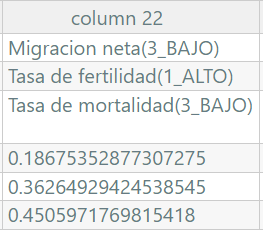

In [379]:
# Variable Elimination

inference_1 = VariableElimination(model)
result = inference_1.query(
    variables=var
    , evidence=ev
    )
print(result)

+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población          |   phi(Tasa de crecimiento de la población) |
+==============================================+============================================+
| Tasa de crecimiento de la población(1_ALTO)  |                                     0.1868 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(2_MEDIO) |                                     0.3626 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(3_BAJO)  |                                     0.4506 |
+----------------------------------------------+--------------------------------------------+


In [380]:
# Belief Propagation
inference_2 = BeliefPropagation(model) 
result = inference_2.query(
    variables=var
    , evidence=ev
    )
print(result)

+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población          |   phi(Tasa de crecimiento de la población) |
+==============================================+============================================+
| Tasa de crecimiento de la población(1_ALTO)  |                                     0.1868 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(2_MEDIO) |                                     0.3626 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(3_BAJO)  |                                     0.4506 |
+----------------------------------------------+--------------------------------------------+


## INFERENCIA APROXIMADA

In [381]:
size=1000

In [382]:
# Bayesian Model Sampling
ev_2 = []

for key, value in ev.items():
        state = State(key, value)
        ev_2.append(state)
inference_3 = BayesianModelSampling(model)
result = inference_3.rejection_sample(size=size, evidence=ev_2).get(RT_CRECIMIENTO)
print("#"*50)
print(result.value_counts()/size)
print("#"*50)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.


c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
 87%|████████▋ | 873/1000 [00:00<00:00, 1124.54it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
100%|██████████| 1000/1000 [00:00<00:00, 1163.50it/s]

##################################################
Tasa de crecimiento de la población
3_BAJO     0.438
2_MEDIO    0.377
1_ALTO     0.185
Name: count, dtype: float64
##################################################


In [384]:
# Approximate Inference Using Sampling

inference_4 = ApproxInference(model)
result = inference_4.query(
    variables=var
    , evidence=ev
    , n_samples=size
    )
print(result)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
 91%|█████████ | 910/1000 [00:00<00:00, 1288.68it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
c:\Users\lmher\miniconda3\lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the Da

+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población          |   phi(Tasa de crecimiento de la población) |
+==============================================+============================================+
| Tasa de crecimiento de la población(3_BAJO)  |                                     0.4420 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(2_MEDIO) |                                     0.3720 |
+----------------------------------------------+--------------------------------------------+
| Tasa de crecimiento de la población(1_ALTO)  |                                     0.1860 |
+----------------------------------------------+--------------------------------------------+
